<a href="https://colab.research.google.com/github/TranApril/WLaSDI/blob/main/1DBurgersLS_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#!pip install pysindy
#!pip install torch
#!git clone https://github.com/TranApril/WLaSDI.git
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from itertools import product
import sys,time
import pickle
from WLaSDI.WLaSDI import WLaSDI
from WLaSDI.LaSDI import LaSDI
import torch
from scipy.interpolate import Rbf

### Load necessary data



In [12]:
snapshot_full = pickle.load(open("./WLaSDI/snapshot_git.p", 'rb'))
snapshot_full = snapshot_full[:,:-1].astype('float32')

# testing parameters and data
amp_test = np.array([0.8])
width_test = np.array([1.0])
snapshot_full_FOM = pickle.load(open(f"./WLaSDI/FOM_a{amp_test[0]}_w{width_test[0]}.p",'rb'))
FOM_time = snapshot_full_FOM['time']
snapshot_full_FOM = snapshot_full_FOM['FOM'][:,:-1].astype('float32')

In [13]:
def addNoise(x, noise_ratio):
    signal_power = np.sqrt(np.mean(x**2))
    sigma = noise_ratio*signal_power
    noise = np.random.normal(0, sigma, x.shape)
    xobs = x + noise
    return xobs

snapshot_full = addNoise(snapshot_full, 0).astype('float32')

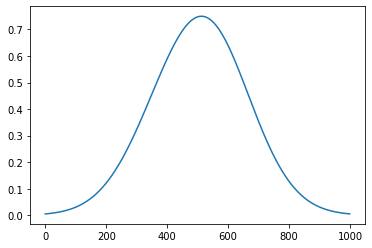

In [14]:
plt.plot(snapshot_full[100])

### Perform SVD to find POD and import simulation parameters

In [15]:
u,s,vh = LA.svd(snapshot_full.T)
sv_mass = np.cumsum(s)
sv_count = 5# [i for i,ss in enumerate(sv_mass) if ss/sv_mass[-1]>.99][0]+1
s[sv_count:] = 0
print(sv_count, sv_mass[:sv_count]/sv_mass[-1])
phi = u[:,:sv_count]

nx = 1001
dx = 6 / (nx - 1)
nt = 1000
tstop = 1
x=np.linspace(-3, 3, nx)

dt = tstop / nt 
c = dt/dx
t = np.linspace(0, tstop, nt)

5 [0.8651299  0.94953    0.98154086 0.9910535  0.99695814]


In [16]:
amp_arr = np.array([0.75,0.85])
width_arr = np.array([0.95,1.05])
P = list(product(amp_arr, width_arr))
P = np.array(P)

ndata = snapshot_full.shape[0]
nset = int(ndata/(nt+1))

latent_space_LS_list = []

for foo in range(nset):
    latent_space_LS = np.matmul(phi.T, snapshot_full[foo*(nt+1):(foo+1)*(nt+1)].T).T
    latent_space_LS_list.append(latent_space_LS)

### Generate LaSDI and WLaSDI-LS model

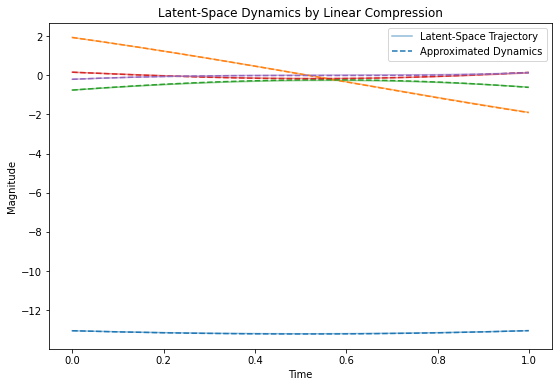

In [17]:
degree = 1
normal = 1
LaSDI_model_LS = LaSDI(phi.T, phi, Local = True, Coef_interp=False, Coef_interp_method=Rbf, nearest_neigh=4)
LaSDI_model_LS_coef = LaSDI_model_LS.train_dynamics(latent_space_LS_list, P, dt, degree = degree, LS_vis = True)
FOM_recon_LaSDI_LS = LaSDI_model_LS.generate_ROM(snapshot_full_FOM[0], np.array([0.8,1.0]),t)

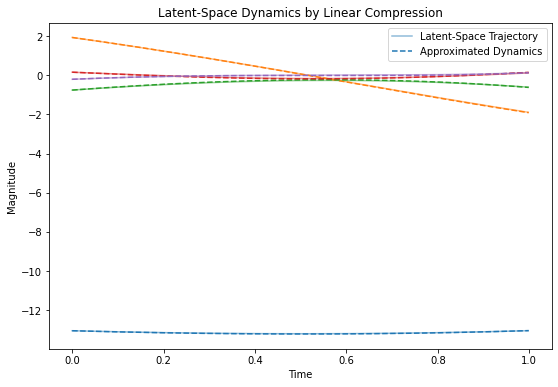

In [18]:
degree = 1
normal = 1
WLaSDI_model_LS = WLaSDI(phi.T, phi, Local=True, Coef_interp=False, Coef_interp_method=Rbf, nearest_neigh=4)
WLaSDI_model_LS_coef = WLaSDI_model_LS.train_dynamics(latent_space_LS_list, P, dt, degree = degree, gamma = 0, overlap=0.5, L = 60, LS_vis=True)
FOM_recon_WLaSDI_LS = WLaSDI_model_LS.generate_ROM(snapshot_full_FOM[0], np.array([0.8,1.0]),t)

### Generate ROM and visualize results

Final Position Error: 0.488%


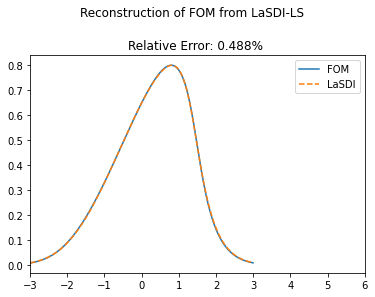

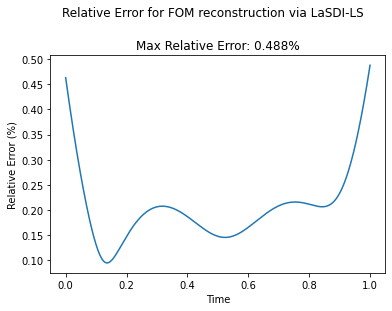

In [19]:
print('Final Position Error: {:.3}%'.format(LA.norm(FOM_recon_LaSDI_LS[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100))
fig = plt.figure()
ax = plt.axes()
fig.suptitle('Reconstruction of FOM from LaSDI-LS', y = 1.05)
ax.set_title('Relative Error: {:.3}% '.format(LA.norm(FOM_recon_LaSDI_LS[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100))
ax.plot(x[:-1],snapshot_full_FOM[-1], label = 'FOM')
ax.plot(x[:-1], FOM_recon_LaSDI_LS[-1],'--', label = 'LaSDI')
ax.legend()
ax.set_xlim(-3,6)


FOM_re = np.empty(nt)
for i in range(nt):
    FOM_re[i] = LA.norm(FOM_recon_LaSDI_LS[i]-snapshot_full_FOM[i])/LA.norm(snapshot_full_FOM[i])

fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via LaSDI-LS', y = 1.05)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(FOM_re)*100))
ax.plot(t, FOM_re*100)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')
torch.cuda.empty_cache()
plt.show()

Final Position Error: 0.488%


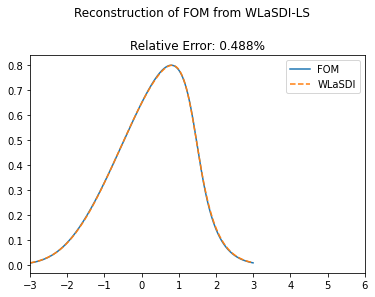

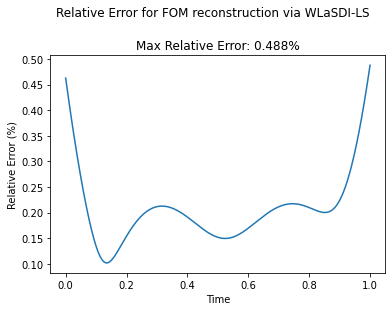

In [20]:
print('Final Position Error: {:.3}%'.format(LA.norm(FOM_recon_WLaSDI_LS[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100))
fig = plt.figure()
ax = plt.axes()
fig.suptitle('Reconstruction of FOM from WLaSDI-LS', y = 1.05)
ax.set_title('Relative Error: {:.3}%'.format(LA.norm(FOM_recon_WLaSDI_LS[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100))
ax.plot(x[:-1],snapshot_full_FOM[-1], label = 'FOM')
ax.plot(x[:-1], FOM_recon_WLaSDI_LS[-1],'--', label = 'WLaSDI')
ax.legend()
ax.set_xlim(-3,6)


FOM_re = np.empty(nt)
try:
    for i in range(nt):
        FOM_re[i] = LA.norm(FOM_recon_WLaSDI_LS[i]-snapshot_full_FOM[i])/LA.norm(snapshot_full_FOM[i])
except:
    print('error')

fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via WLaSDI-LS', y = 1.05)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(FOM_re)*100))
ax.plot(t, FOM_re*100)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')
torch.cuda.empty_cache()
plt.show()